# MANUAL DE LABORATORIO DE COMUNICACIONES DIGITALES: PYTHON
F. Javier Payán Somet, Juan José Murillo-Fuentes, José Carlos Aradillas Jaramillo \
_Departamento de Teoría de la Señal y Comunicaciones_ \
_Escuela Técnica Superior de Ingeniería_ \
_Universidad de Sevilla_ 

# Tema 7. Sistema de Comunicación Digital Lineal

**Este notebook contiene código del Tema 7**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/gapsc-us/labcomdig/blob/main/Tema7.Sistema_Comunicacion_Digital_Lineal.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Inicialización

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Numpy ≥1.16 is required
import numpy as np
assert np.__version__ >= "1.16"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore") #Ignorar warnings

## Sistema de comunicación digital binario

Las funciones que se describen aquí están en el fichero labcomdig.py y se definieron en temas anteriores, se usan a continuación por código 7.1. Se incluyen aquí para recordarlas, y para facilitar la ejecución en google colab, pero si se dispone del fichero labcomdig.py bastaría con ejecutar en vez de incluir las 3 siguientes funciones.

**from labcomdig import transmisorpam, Qfunct** 

In [2]:
def transmisorpam(Bn,Eb,M,p,L):
    '''
    [Xn,Bn,An,phi,alfabetopam] = transmisorpam(Bn,Eb,M,p,L) 
    
    Entradas:    
     Bn = Secuencia de dígitos binarios
     Eb = Energía media por bit transmitida en Julios
     M  = Número de síímbolos del código PAM
     p  = Pulso paso de baja o paso de banda 
     L  = Número de puntos a utilizar en la representación de un símbolo
    
    Devuelve:
     Xn = la señal de información (discreta)
     Bn = La secuencia de dígitos binarios realmente transmitidos
     An = La secuencia de niveles de amplitud transmitidos
   	 phi = Pulso básico real normalizado (energía unidad)
     alfabetopam = Los niveles de amplitud asociados a cada símbolo
    '''    
    #Comprobación de parámetros de entrada
    p=p.squeeze()
    if len(Bn)<1 or Eb<=0 or M<2 or p@p==0 or L<1:
        raise Exception('Error: revise los parámetros de entrada')
    
    # Se obtienen en primer lugar los niveles asociado a cada símbolo ¿Cuántos bits hay en cada sí­mbolo?
    k = int(np.ceil(np.log2(M)))   
    M = 2**(k) # Se Ajusta M a una potencia de dos
    
    # El alfabeto [Ver la ecuación (4.21)] 
    alfabetopam = np.sqrt(3*Eb*np.log2(M)/(M**2-1))*(2*(np.arange(M))-M+1)
    
    # Si Bn no tiene una longitud múltiplo de k, se completa con ceros
    Nb = len(Bn)  # Número de bits a transmitir, actualizado
    Bn = Bn.squeeze().astype(int) #Comprobación de int y dimensiones   
    Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)] #
    Nb = len(Bn)  # Número de bits a transmitir tras la corrección
    Ns = Nb//k # Número de símbolos a transmitir
    
    # La secuencia generada
    if M>2:
        An = alfabetopam[gray2de(np.reshape(Bn,[Ns,k]))]
    else:
        An = alfabetopam[Bn]
    
    # Comprobación de las longitudes y otros datos del pulso suministrado para 
    # hacer que el número de muestras del mismo sea efectivamente L
    Ls = len(p)
    if Ls<L:
        p = np.r_[p, np.zeros(L-Ls)]
    elif Ls>L:
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))
        p = p[:L] #Debe modificarse si se quiere un pulso de más de L muestras 
    # Se normaliza la energía del pulso para obtener la base del sistema
    phi = p / np.sqrt(p@p) 
       
    # Obtención del tren de pulsos, Xn = np.kron(An,phi) ó
    Xn = np.reshape(np.reshape(An,[Ns,1])*phi,[Ns*L,]) #Debe modificarse si se quiere un pulso de más de L muestras
    return [Xn,Bn,An,phi,alfabetopam]

También se necesita, en la función anterior y también presentada en un tema anterior:

In [3]:
def gray2de(b):
    '''
    Convierte cada columna de la matriz formada por dígitos binarios b en un vector
        fila de los valores decimales correspondientes, aplicando codificación de Gray.
    '''
    if not isinstance(b, (np.ndarray, list, tuple)):  # se comprueba que no sea np.array, lista o tupla
       raise Exception('Error: la entrada no es un array, lista o tupla')
    b = np.array(b)    # Esto es para que admita también listas y tuplas
    c = np.zeros_like(b); c[:,0] = b[:,0]
    for i in range(1,np.shape(b)[1]):
        c[:,i] = np.logical_xor(c[:,i-1], b[:,i])
    c = np.fliplr(c) # Convierte los bits menos significativos en los más significativos
    #Comprueba un caso especial.
    [n,m] = np.shape(c) 
    if np.min([m,n]) < 1:
        d = []
        return
    d = c @ 2**np.arange(m)
    return d 

También se necesita, en el código abajo, la función Qfunct, introducida en temas anteriores:

In [4]:
def Qfunct(x):
    ''' 
     y = Qfunct(x) evalúa la función Q en x.
    Donde y = 1/sqrt(2*pi) * integral desde x hasta inf de exp(-t^2/2) dt
    '''
    from scipy.special import erfc 
    from numpy import sqrt
    y=(1/2)*erfc(x/sqrt(2)) 
    return y

**Código 7.1** Sistema de comunicación digital binario.

In [5]:
#%% Inicialización
Nb = 10**6 # Nb = Nº de bits a transmitir
Eb = 9 # Eb = Energía media transmitida en Julios
M = 2
L = 4 # L =  Nº de puntos que vamos a utilizar para transmitir un bit

In [6]:
# Definición del pulso básico. 
p = np.ones(L)

In [7]:
#%% Secuencia binaria generada por la fuente
Bn = np.random.randint(2,size=Nb)  # Bn = Secuencia de dígitos binarios

In [8]:
#%% Transmisor PAM
[Xn,Bn,An,phi,alfabeto] = transmisorpam(Bn,Eb,M,p,L)
# Actualiza el valor de Nb
Nb = len(Bn)

In [9]:
#%% Receptor Vectorial
# Alternativa 1) receptor vectorial usando filtros
#hr = np.flipud(phi) #Respuesta impulsiva del filtro adaptado
#yn = np.convolve(hr,Xn,'valid') # Salida del filtro adaptado
#sn = yn[np.arange(0,Nb*L,L)] # El resultado de muestrear la señal anterior
     
# Alternativa 2) receptor vectorial usando correlación
sn = np.reshape(Xn,[Nb,L]) @ phi 

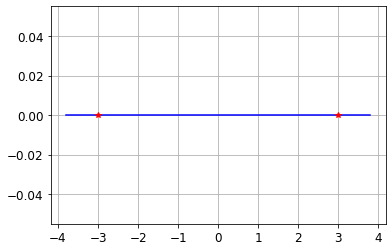

In [10]:
#%%Representación de la Constelación
# Se obtienen valores únicos
sx = np.unique(sn)

# Distancia mínima de la constelación
dmin = abs(sx[0]-sx[1])

# Representamos
xmax = max(sx)+max(sx)/10+0.5
xmin = -(abs(min(sx))+abs(min(sx))/10)-0.5
plt.figure(71)
plt.plot([xmin,xmax],[0,0],'b-'); # Se representan los ejes
plt.plot(sx,np.zeros(len(sx)), 'r*') # Se representa la constelación
plt.grid()

In [11]:
#%% Estimación mediante simulación de Monte Carlo de la tasa de error de bit

SNRdb = np.arange(20)  # SNR en dB donde estimar la BER estimada por MC

# Inicialización
berSimulado = np.zeros(len(SNRdb))

for ii in range(len(SNRdb)):
    # Generamos ruido
    SNR = 10**(SNRdb[ii]/10) # relación señal ruido en unidades naturales
    varzn = Eb/(2*SNR) #varianza del ruido
    # El ruido del canal
    Wn = np.sqrt(varzn)*np.random.randn(np.size(Xn))
    
    # Salida del Canal AWGN: señal más el ruido
    rn = Xn + Wn
    
    #Salida del Receptor Vectorial
    #Alternativa 1, receptor vectorial basado en filtros
    #vn = np.convolve(hr, rn, 'valid') # Filtrado por filtro adaptado
    #r = vn[np.arange(0,Nb*L,L)]  # Se muestrea

    #Alternativa 2, receptor vectorial basado en correlador
    r = np.reshape(rn,[Nb,L]) @ phi  

    #Salida del Detector. El umbral está situado en sx(1)+sx(2))/2
    correctos = (r>(sx[0]+sx[1])/2) == (Bn) #ó = np.equal(r>(sx[0]+sx[1])/2,Bn)
    
    #Estimamos la tasa de error de bit para esa SNR
    errores = Nb-np.sum(correctos)
    berSimulado[ii]=errores/Nb #BER para SNRdb[ii]
    

In [12]:
#%% Cálculo de BER teórica    
SNRdb2 = np.arange(20, step=0.1)  #SNR donde calcular la BER teórica
SNR2 = 10**(SNRdb2/10) #Paso a unidades naturales
berTeorico = Qfunct(np.sqrt(2*SNR2))

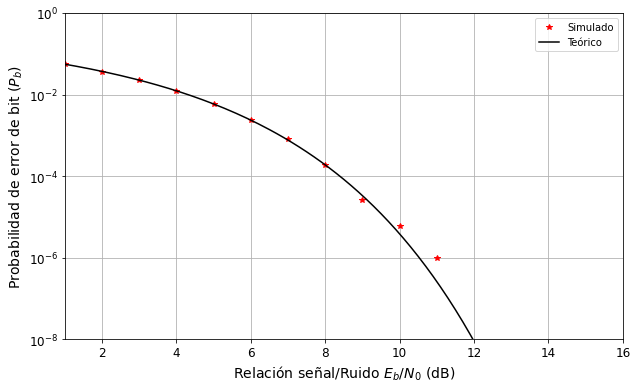

In [13]:
#%% Representación de las probabilidades de error
plt.figure(72,figsize = (10,6))
plt.semilogy(SNRdb,berSimulado,'r*');
plt.semilogy(SNRdb2,berTeorico,'k-');
plt.axis([1, 16, 10**(-8), 1]), plt.grid()
plt.xlabel('Relación señal/Ruido $E_b/N_0$ (dB)')
plt.ylabel('Probabilidad de error de bit ($P_b$)')
plt.legend(['Simulado','Teórico'],loc='best') # Crea leyenda
plt.show()

Fin código 7.1

##  Sistema de comunicación digital M-PAM


En este tema se presentan las siguientes funciones:

**Código 7.2** Función detecta

In [14]:
def detecta(r, alfabeto):
    '''
    An = detecta(r, alfabeto)
    r = secuencia a la entrada del detector, con estimaciones de s_i
    alfabeto = tabla con los niveles de amplitud/sí­mbolos  
    
    Genera:
    An = una secuencia de sí­mbolos pertenecientes al alfabeto de acuerdo con
    una regla de distancia euclidiana mí­nima (mí­nima distancia)
    '''
    
    # Longitud de la secuencia                
    N = len(r)
    
    # Inicializa
    An = np.zeros(N)
    
    for i in range(N):
        ind = np.argmin(abs(r[i]-alfabeto)) #ind = np.where(abs(r[i]-alfabeto) == np.amin(abs(r[i]-alfabeto)))
        An[i] = alfabeto[ind]
    
    return An


**Código 7.3** Función detecta Sin el Bucle For.

In [15]:
def detectaSBF(r,alfabeto):
    '''
    An = detectaSBF(r,alfabeto)
    r = secuencia a la entrada del detector, con estimaciones de s_i
    alfabeto = tabla con los niveles de amplitud/símbolos  
    
    Genera:
    An = una secuencia de símbolos pertenecientes al alfabeto de acuerdo con
    una regla de distancia euclidiana mínima (mínima distancia)
    '''
    
    # Obtiene el índice respecto al alfabeto
    ind = np.argmin(np.abs(np.repeat(np.expand_dims(r,1),len(alfabeto),1) - alfabeto), 1)
    
    # Genera la secuencia de niveles detectados
    An = alfabeto[list(ind)]
    
    return An

**Código 7.4** Función simbolobit.

In [16]:
def simbolobit(An,alfabeto):
    '''
    Bn = simbolobit(An, alfabeto)
    An = secuencia de símbolos pertenecientes al alfabeto
    alfabeto = tabla con los símbolos utilizados en la transmisión 
    Bn = una secuencia de bit, considerando que los símbolos se habían
    generado siguiendo una codificación de Gray
    '''
    
    k = np.log2(len(alfabeto)) # bits por símbolo
    
    if k>1:
        distancia = abs(alfabeto[0]-alfabeto[1])
        indices   = np.round((An-alfabeto[0])/distancia)
        Bn        = np.reshape(de2gray(indices,k),[int(k*len(An))])
    else:
        Bn = ((An/max(alfabeto))+1)/2
    
    return Bn

En esta función se hace una llamada a la función de2gray utilizando la librería *sympy*.
Su código es el siguiente:

**Código 7.5** Función de2gray.

In [17]:
def de2gray(d,n):
    """
    b = de2gray(d,n)
    Convierte un número decimal, d, en un vector binario, b, de longitud n
    """   
    c = np.zeros([len(d),int(n)])
    for i in range(int(n)): 
        d, c[:,i] = np.divmod(d,2)
        
    c = np.fliplr(c); 
    b = np.zeros_like(c); 
    b[:,0] = c[:,0]; aux = b[:,0]
    for i in range(1,int(n)):
        b[:,i] = np.logical_xor(aux, c[:,i])
        aux = np.logical_xor(b[:,i], aux) 
        
    return np.reshape(b,[-1]).astype(np.int)

El siguiente código es una extensión del anterior para modulaciones M-arias, ejecutándose para varios valores de M
 
**Código 7.6** Sistema de comunicación digital M-PAM.

In [18]:
#%% Inicialización
verbose = 1 # Para indicar por pantalla el progreso de la ejecución
L = 4 #Número de muestras por símbolo transmitidas
Nb = 10**5  #Número de bits a transmitir
Eb = 9 #Energía promedo de bit
p = np.ones(L) # definamos el pulso básico

#Colores RGB para representa curvas:
codigocolor = np.array([[0,0,0], [0,1,0], [0,0,1], [1,0,0], [1,0,1], [0,1,1]])
jj=0 # variable auxiliar para bucle for



Simulando sistema PAM con M=2
 Simulando SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
Calculando tasa de error de símbolo teórica
Calculando tasa de error de bit teórica
Representando resultados


Simulando sistema PAM con M=4
 Simulando SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
Calculando tasa de error de símbolo teórica
Calculando tasa de error de bit teórica
Representando resultados


Simulando sistema PAM con M=8
 Simulando SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
Calculando tasa de error de símbolo teórica
Calculando tasa de error de bit teórica
Representando resultados


Simulando sistema PAM con M=16
 Simulando SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
Calculando tasa de error de símbolo teórica
Calculando tasa de error de bit teórica
Representando resultados


Simulando sistema PAM con M=32
 Simulando SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,

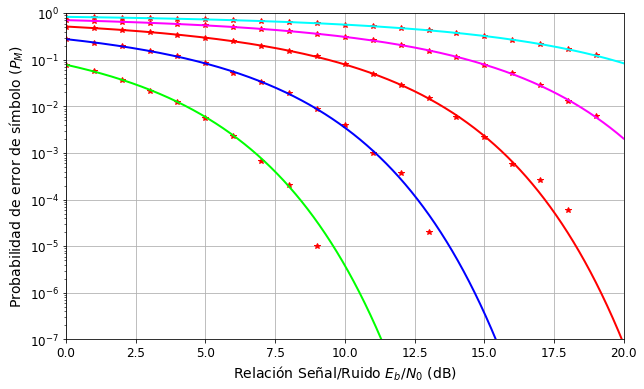

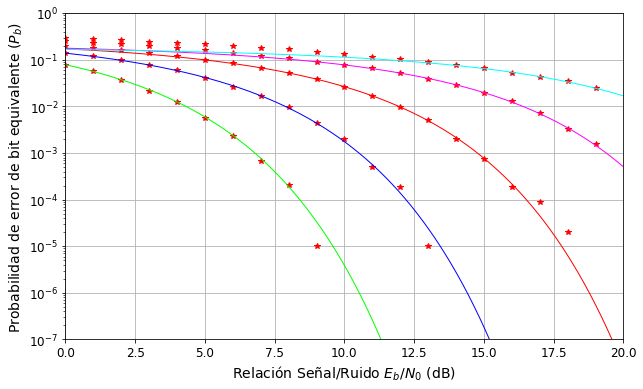

In [19]:
#%% Calculamos para cada M la estimación mediante simulación de la probabilidad
# de error de símbolo y de bit equivalente
for M in np.array([2, 4, 8, 16, 32]):  
    if verbose: print('\n\nSimulando sistema PAM con M={}'.format(M))
    jj = jj+1;
    Bn = np.random.randint(2,size=Nb)   
    
    [Xn,Bn,An,phi,alfabeto] = transmisorpam(Bn,Eb,M,p,L)
    #[Secuencia Tx, Bits Tx, Símbolos Tx, pulso usado, constelación]

    Nb = len(Bn) #Número de bits transmitidos
    Ns = len(An) #Número de símbolos transmitidos

    # Definamos la relación señal ruido en dB y otros elementos 
    SNRdb = np.arange(20)
    serSimulada = np.zeros(len(SNRdb))
    berSimulada = np.zeros(len(SNRdb))
    if verbose: print(' Simulando SNR = ', end = '')
    for ii in range(len(SNRdb)):
        if verbose: print('{}, '.format(SNRdb[ii]), end = '')
        SNR = 10**(SNRdb[ii]/10)
        varzn = Eb/(2*SNR)
    
        # El ruido (AWGN) 
        Wn = np.sqrt(varzn)*np.random.randn(np.size(Xn))
        
        # Salida del Canal AWGN: la señal Tx más el ruido
        rn = Xn + Wn
    
        # Salida del Receptor Vectorial o Demodulador, usando correlador
        r = np.dot(np.reshape(rn,[Ns,L]), phi)

        # Salida del Detector 
        Andetectado = detectaSBF(r, alfabeto) #Símbolos detectados
        erroresSimbolo = Ns-sum(Andetectado==An) # Nº Errores de símbolo
        serSimulada[ii] = erroresSimbolo/Ns  
        
        Bndetectado = simbolobit(Andetectado, alfabeto) #Bits detectados
        erroresBit = Nb-sum(Bndetectado==Bn) # Nº Errores de bit
        berSimulada[ii] = erroresBit/Nb
  
    # Cálculo de la probabilidad o tasa de error teórico
    SNRdb2 = np.arange(20, step=0.01) #SNR donde calcular la BER teórica
    SNR2 = 10**(SNRdb2/10) #paso a unidades naturales
    if verbose: print('\nCalculando tasa de error de símbolo teórica')      
    serTeorico = (2*(M-1)/M)*Qfunct(np.sqrt((6*np.log2(M)/(M**2-1))*SNR2))
    if verbose: print('Calculando tasa de error de bit teórica') 
    berTeorico = serTeorico/np.log2(M)

    # Representación de las tasas de error de símbolo y bit, teórica y simuladas
    if verbose: print('Representando resultados')  
    color = codigocolor[jj,:]  
    plt.figure(73,figsize=(10,6))  # SER 
    plt.semilogy(SNRdb,serSimulada,'r*')
    plt.semilogy(SNRdb2,serTeorico,'-k',color=color, linewidth=2)
    plt.axis([0,20,10**-7,1])
    plt.grid()
    plt.xlabel('Relación Señal/Ruido $E_b/N_0$ (dB)');
    plt.ylabel('Probabilidad de error de símbolo ($P_M$)');
    plt.figure(74,figsize=(10,6)) # BER 
    plt.semilogy(SNRdb,berSimulada,'r*')
    plt.semilogy(SNRdb2,berTeorico,'-k',color=color, linewidth = 1)
    plt.axis([0,20,10**-7,1])
    plt.grid()
    plt.xlabel('Relación Señal/Ruido $E_b/N_0$ (dB)')
    plt.ylabel('Probabilidad de error de bit equivalente ($P_b$)')

plt.show()

## Ejercicio propuesto (básico)

Basándose en el sistema de comunicación PAM banda base diseñado en la Sección 7.2, en este Ejercicio Básico se desea diseñar un sistema de comunicación PAM paso de banda M-ario en un canal AWGN y comprobar sus prestaciones para diversos valores de M y relación señal/ruido. En concreto:

**1.** Diseñar un transmisor paso de banda mediante la función transmisorpam, cuando: 

 - $N_b = 10^6$ bits  
 - $M = 8$.
 - $E_b = 8$ Julios.
 - $L = 32$.
 - El pulso conformador se muestra en la Figura 7.7 (ver a contiuación).
 - Frecuencia portadora $\omega_c = 8\pi/T$.
 - $R_b = 10^4$ bps.

<img src=https://raw.githubusercontent.com/gapsc-us/labcomdig/main/figures/pulsoConformador.png style="max-width:30%;width:auto;height:auto;" align="center">

**2.** Representar la señal discreta transmitida para los primeros 10 símbolos generados.

**3.** Representar la señal continua transmitida para los primeros 10 símbolos generados.

**4.** Determinar la energía de la señal transmitida. ¿Coincide la energía media por bit transmitida con la elegida en el diseño? Razonar la posible discrepancia.

**5.** Demodular la señal transmitida cuando se utiliza un demodulador que utiliza un único correlador, en ausencia de ruido.

**6.** Representar la respuesta impulsiva discreta de un filtro adaptado que pudiera utilizarse como parte de un demodulador. Demodular la señal transmitida cuando se utiliza un demodulador que utiliza el filtro adaptado, en ausencia de ruido.

**7.** Determinar los posibles niveles a la entrada del detector, en ausencia de ruido.

**8.** Determinar la varianza del ruido presente a la entrada del detector cuando la relación Ebav/N0 = 16 dB. ¿Cuáles serían los umbrales de detección MAP?

**9.** La probabilidad de error de símbolo PM y la probabilidad de error de bit equivalente Pb pueden obtenerse a partir de las ecuaciones (7.1) y (7.2). Representarlas frente a Ebav/N0 medido en decibelios cuando Ebav/N0 varía entre 0 y 20 dB.

**10.** Utilizando una secuencia de Nb = $10^6$ bits transmitidos, comprobar experimentalmente que los valores de Pb obtenidos concuerdan con los teóricos cuando la relación Ebav/N0 varía entre 0 y 20 dB.

# Ejercicio propuesto

Basándose en el receptor PAM diseñado, en este ejercicio se desea diseñar un sistema 32-QAM rectangular en banda base y obtener experimentalmente la probabilidad de error de bit equivalente de la misma. Debido a su posible complejidad, se propone un guión de cómo se podría realizar este diseño.

**1.** Diseñar un transmisor paso de banda mediante la función transmisorpam, cuando:
 - $N_b = 10^6$
 - $M = 8$
 - $E_b = 8$ Julios.
 - $L = 32$.
 - El pulso conformador se muestra en la Figura 7.7 (ver abajo).
 - Frecuencia portadora $\omega_c = 8\pi/T$.
 - $R_b = 10^4$ bps.
 
 <img src=https://raw.githubusercontent.com/gapsc-us/labcomdig/main/figures/pulsoConformador.png style="max-width:30%;width:auto;height:auto;" align="center">

**2.** El receptor estará formado por dos receptores PAM diseñados mediante correladores. Asuma que no hay canal, esto es que el transmisor y receptor están conectados directamente.

**3.** Si llamamos {ÂnI} a la secuencia de símbolos detectados en la componente en fase y {ÂnQ} a los detectados en la componente en cuadratura, hacer uso de la función simbolobit para obtener las correspondientes secuencias de bits de las componentes en fase y cuadratura, {B̂nI} y {B̂nQ}, respectivamente.

**4.** La secuencia de bit detectada debe obtenerse intercalando las secuencias de bit anteriores. Esta operación puede realizarse con facilidad mediante el uso de la función que se ha denominado une, que realiza la operación simétrica a la función split. Una posible realización de esta función une se muestra en el siguiente código.

Pb = Ne
log2 M1 + log2 M2
Q
⎡⎢⎢⎣
Ì
6(log2 M1 + log2 M2)
M2
1 + M2
2 − 2
Ebav
N0
⎤⎥⎥⎦
(7.3)
siendo Ne el número medio de puntos que comparten frontera, que en el caso de una
constelación rectangular QAM viene dado por:
Ne = 4(1 − 1
2M1
− 1
2M2
). (7.4)
Compare el resultado experimental y teórico.

In [20]:
def une(BndetectadoI,BndetectadoQ,M1,M2):
    '''
    [Bndetectado]=une(BndetectadoI,BndetectadoQ,M1,M2)
    BndetectadoI = una secuencia de símbolos binarios correspondientes a los
    bits en posiciones múltiplos de k1
    BndetectadoQ = una secuencia de símbolos binarios correspondientes a los
    bits en posiciones múltiplos de k2
    M1 = nº de símbolos de la componente en fase
    M2 = nº de símbolos de la componente en cuadratura
    '''
    # Devuelve
    # Bndetectado = Los bits entremezclados
    import numpy as np
    k1 = np.log2(M1)
    k2 = np.log2(M2)
    N = len(BndetectadoI)/k1
    C1 = np.reshape(BndetectadoI,[int(N),int(k1)])
    C2 = np.reshape(BndetectadoQ,[int(N),int(k2)])
    C = np.c_[C1,C2]
    Bndetectado = np.reshape(C,[int(N*(k1+k2))])
    return Bndetectado

**5.** Obtenga mediante simulación, experimentalmente, cuál es la tasa de error de bit, BER, si se introduce en el sistema anterior un canal AWGN. Estime la BER para un rango entre 0 y 20 dB.

**6.** La probabilidad de error de bit equivalente del sistema QAM se obtendrá comparando la secuencia de dígitos binarios transmitidos y los detectados. A efectos de comparación, se sabe que esta probabilidad de error viene dada por:

$$P_b = \frac{N_e}{log_2 M_1 + log_2 M_2} Q\left[\sqrt{\frac{6(log_2 M_1 + log_2 M_2}{M_1^2 + M_2^2 -2}\frac{E_{bav}}{N_0}}\right]$$

siendo Ne el número medio de puntos que comparten frontera, que en el caso de una constelación rectangular QAM viene dado por:

$$ N_e = 4\left(1 - \frac{1}{2M_1} - \frac{1}{2M_2}\right)$$

Compare el resultado experimental y teórico.

**7.** Repetir todos los puntos anteriores utilizando únicamente la función transmisorpam para generar la señal QAM.
**8.** Repetir todos los puntos anteriores utilizando la función transmisorqamVC diseñada en el Ejercicio 5.7.

**8.** Repetir todos los puntos anteriores utilizando la función transmisorqamVC diseñada en el Ejercicio 5.7.